# Transfer Learning with Tensorflow

# Part1: Feature Extraction

> Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problems

There are two main benefits:
* Can leverage existing neural network architecture proven to work on problems similar to our own
* Can leverage working neural network architecture which has already learned pattern similar to our own and we can adapt those patterns on our own.

In [1]:
!nvidia-smi

Thu Apr 25 15:24:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Download and become one with data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzipping the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")

zip_ref.extractall()
zip_ref.close()

--2024-04-25 15:25:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   152MB/s    in 1.1s    

2024-04-25 15:25:04 (152 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

# walk through data directory

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 10 directori

In [4]:
# Using ImageDataGenerator to load data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

print("Training data: ")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)

print("Testing data: ")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)

Training data: 
Found 750 images belonging to 10 classes.
Testing data: 
Found 2500 images belonging to 10 classes.


## Callbacks
> Things to run whilist our model trains
> Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks
* Tracking experiments with the Tensorboard Callback
* Model Checkpoint with the ModelCheckpoint Callback
* Stopping a model from training with the EarlyStopping Callback

In [5]:
import tensorflow as tf

In [6]:
# Create Tensorboard Callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving tensorflow log files to: {log_dir}")

  return tensorboard_callback

## Creating models using Tensorflow Hub:

https://paperswithcode.com/

**Efficientnet: https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1?tfhub-redirect=true

**Resnet: https://www.kaggle.com/models/tensorflow/resnet-50/tensorFlow2/feature-vector/1?tfhub-redirect=true

In [7]:
# comparing the models
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/tensorFlow2/feature-vector/1"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [8]:
# importing dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# create model

def create_model(model_url, num_classes = 10):
  """
  Takes a tensorflow hub URL and creates Keras Sequential model with it
  Returns uncompiled keras sequential model with model_url as feature extractor
  layer and Dense output with num_classes output neurons.
  """
  # Download the pretrained model and save it as keras layers
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extractor_layer",
                                           input_shape = IMAGE_SHAPE + (3,)) # freeze already learned patterns
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = "softmax", name= "output_layer")
  ])

  return model

# Resnet50 model

In [10]:
# create Resnet Model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [11]:
IMAGE_SHAPE + (3 , )

(224, 224, 3)

In [12]:
# summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 2048)              23561152  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23581642 (89.96 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23561152 (89.88 MB)
_________________________________________________________________


In [13]:
# Compile the resnet model
resnet_model.compile(
    loss = "CategoricalCrossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [14]:
# Fit the model
history_res = resnet_model.fit(
    train_data_10_percent,
    epochs = EPOCHS,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", experiment_name = "Resnet50_v2")]
)

Saving tensorflow log files to: tensorflow_hub/Resnet50_v2/20240425-152621
Epoch 1/5
24/24 [==============================] - 25s 635ms/step - loss: 2.0833 - accuracy: 0.3053 - val_loss: 1.1626 - val_accuracy: 0.6336
Epoch 2/5
24/24 [==============================] - 12s 518ms/step - loss: 0.9232 - accuracy: 0.7147 - val_loss: 0.7274 - val_accuracy: 0.7808
Epoch 3/5
24/24 [==============================] - 12s 506ms/step - loss: 0.6221 - accuracy: 0.8067 - val_loss: 0.6198 - val_accuracy: 0.8120
Epoch 4/5
24/24 [==============================] - 12s 492ms/step - loss: 0.4819 - accuracy: 0.8827 - val_loss: 0.5792 - val_accuracy: 0.8196
Epoch 5/5
24/24 [==============================] - 11s 479ms/step - loss: 0.3689 - accuracy: 0.9067 - val_loss: 0.5461 - val_accuracy: 0.8316


<Axes: >

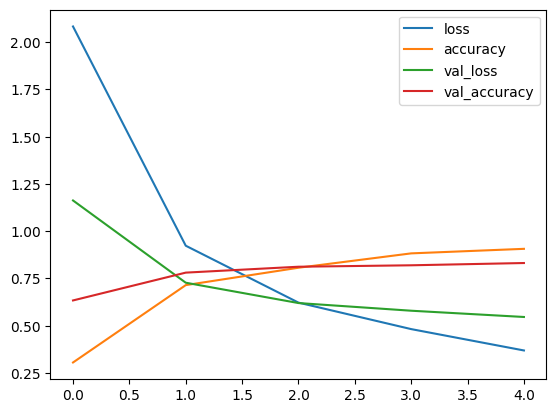

In [15]:
import pandas as pd

pd.DataFrame(history_res.history).plot()

In [16]:
# plotting loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics
  Args:
  history: Tensorflow History object

  Returns: Plot of training and validation loss

  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # plot the loss curves
  plt.plot(epochs, loss, label = "Training loss")
  plt.plot(epochs, val_loss, label = "Validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "Accuracy")
  plt.plot(epochs, val_accuracy, label = "Val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

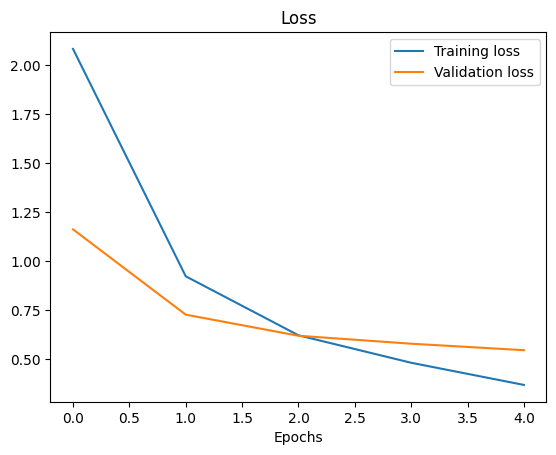

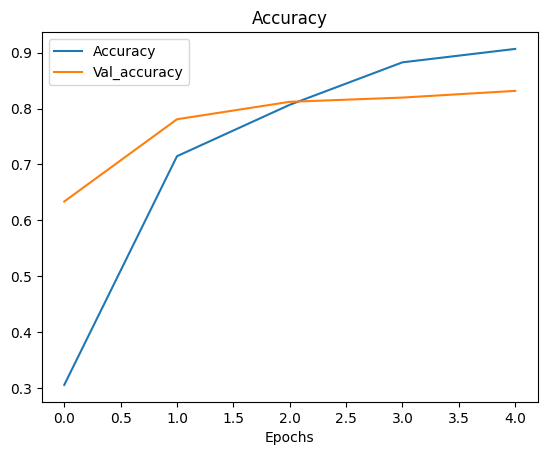

In [17]:
plot_loss_curves(history_res)

# Efficientnet Model

In [18]:
efficientnet_model = create_model("https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1",
                                  num_classes = train_data_10_percent.num_classes)

# compiling the model
efficientnet_model.compile(
    loss = "CategoricalCrossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [21]:
history_effnet = efficientnet_model.fit(train_data_10_percent,
                                        epochs  = EPOCHS,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = len(test_data),
                                        callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", experiment_name = "efficientnetb0")]
                                        )

Saving tensorflow log files to: tensorflow_hub/efficientnetb0/20240425-153102
Epoch 1/5
24/24 [==============================] - 26s 653ms/step - loss: 1.8334 - accuracy: 0.4520 - val_loss: 1.2782 - val_accuracy: 0.7320
Epoch 2/5
24/24 [==============================] - 13s 543ms/step - loss: 1.0347 - accuracy: 0.7733 - val_loss: 0.8566 - val_accuracy: 0.8220
Epoch 3/5
24/24 [==============================] - 11s 452ms/step - loss: 0.7331 - accuracy: 0.8400 - val_loss: 0.6901 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 11s 453ms/step - loss: 0.5901 - accuracy: 0.8787 - val_loss: 0.6026 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 10s 436ms/step - loss: 0.4980 - accuracy: 0.8880 - val_loss: 0.5513 - val_accuracy: 0.8624


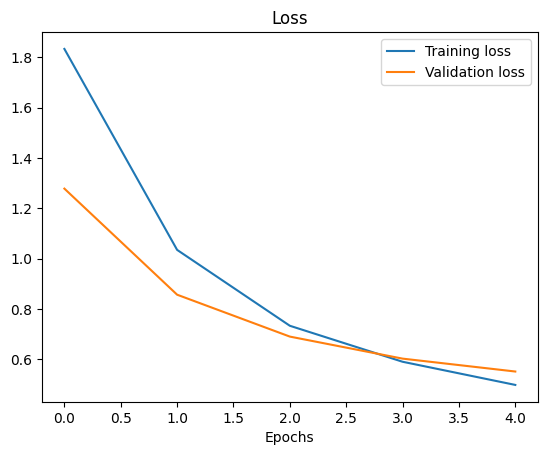

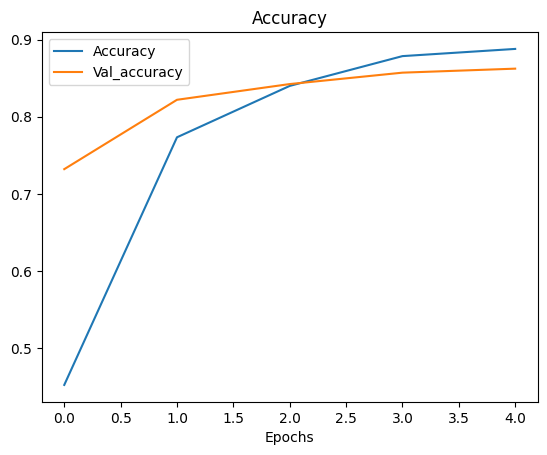

In [22]:
plot_loss_curves(history_effnet)

In [23]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1280)              4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [26]:
len(efficientnet_model.layers[0].weights)

309

# Different types of Transfer Learning
* "As is" transfer learning - using an existing model with no changes whatsoever e.g using imagenet model on 1000 Imagenet classes
* "Feature Extraction" - use the prelearned patterns of an existing model e.g efficientnetB0 trained on Imagenet
* "Fine Tuning Transfer Learning" - use the prelearned patterns of an existing model and "fine tune" many or all of the underlying layers including new output layers

# Comparing Models

**Tensorboard**
* a way to visually explore our machine learning models performance and internals
* Host, track and share machine learning experiments

In [27]:
# upload tensorboard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF HUB feature extraction model architectures using 10 percent of training data" \
  --one_shot

2024-04-25 15:52:10.880541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 15:52:10.880606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 15:52:10.881918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 15:52:11.928535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb